In [3]:
from pycalphad import Database, calculate, Model, ReferenceState, variables as v
import matplotlib.pyplot as plt
from pycalphad.core.utils import unpack_components, get_pure_elements, wrap_symbol
from pycalphad import equilibrium

#dbf = Database('Updated_Mn5G3_species_Mn-Ge-Si.tdb')
dbf = Database('Mn-Si-Ge.tdb')
phases = list(dbf.phases.keys())


comps = ["MN","GE"]

conds = {v.N: 1, v.P: 101325, v.T: 1900, v.X('MN'):0.25}  # make sure to add more composition conditions if you add more components



new_components={'MN':{'MN':1,'GE':0},'MN5GE3':{'MN':5,'GE':3}}
#new_components={'MN':{'MN':1,'GE':0},'GE':{'MN':0,'GE':1}}

#Mn_ref = ReferenceState("MN5GE3", "LIQUID")
Mn_ref = ReferenceState("GE", "LIQUID")
Ge_ref = ReferenceState("MN", "LIQUID")


liq_refstates = [Mn_ref, Ge_ref]


mod_liq = Model(dbf, comps, 'LIQUID')
mod_liq.shift_reference_state(liq_refstates, dbf)
calc_models={'LIQUID':mod_liq}

model_pure_elements = get_pure_elements(dbf, comps)

result = calculate(dbf, comps, "LIQUID", P=101325, T=1770, output="HMR",model=calc_models)
#result = calculate(dbf, comps, "LIQUID", P=101325, T=1770, output="HM")

#eq = equilibrium(dbf, comps, phases, conds, output='HM', calc_opts={'pdens': 2000})

#fig = plt.figure(figsize=(9,6))
#ax = fig.gca()
#ax.scatter(result.X.sel(component='GE'), result.HMR, marker='.', s=5, label='LIQUID')
#ax.set_xlabel('X(GE)',fontsize=16)
#ax.set_ylabel('HM_MIX',fontsize=16)
#ax.set_title('CrF3-NaF LIQUID Mixing Enthalpy')
#ax.legend()
#plt.show()
print(result)

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, component: 2, internal_dof: 3, points: 10003)
Coordinates:
  * component  (component) <U2 'GE' 'MN'
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 1.77e+03
Dimensions without coordinates: internal_dof, points
Data variables:
    X          (N, P, T, points, component) float64 1.0 1.625e-14 ... 0.3604
    Phase      (N, P, T, points) <U6 'LIQUID' 'LIQUID' ... 'LIQUID' 'LIQUID'
    Y          (N, P, T, points, internal_dof) float64 1.0 1e-14 ... 0.5625
    HMR        (N, P, T, points) float64 -2.856e-10 -1.12e-09 ... -1.859e+04


In [4]:
from pycalphad import Database, calculate, Model, ReferenceState, variables as v
from tinydb import where
import matplotlib.pyplot as plt
import numpy as np
from sympy import exp, log, Abs, Add, And, Float, Mul, Piecewise, Pow, S
from collections import Counter
from pycalphad import equilibrium
from pycalphad.models.model_mqmqa import ModelMQMQA
from ast import literal_eval

dbf = Database("NaF-CrF3.tdb")
comps = ['NA', 'F','CR']


#phases = list(dbf.phases.keys())
phases=['LIQUID']

new_components={'CRF3':{'CR':1,'F':3},'NAF':{'NA':1,'F':1},'F2':{'F':2}}


Na_ref = ReferenceState("NA", "BCC_A2", {v.T: 298.15, v.P: 101325})
Cr_ref = ReferenceState("CR", "BCC_A2", {v.T: 298.15, v.P: 101325})
F_ref = ReferenceState("F", "GAS", {v.T: 298.15, v.P: 101325})

list_of_ref=[Cr_ref,Na_ref,F_ref]
####THIS FUNCTION HELPS DETERMINE WHETHER THERE ARE THE SAME AMOUNT OF COMPONENTS AS THERE ARE IN THE SYSTEM
###AND ALSO HELPS DETERMINE THAT THE ELEMENTS FROM THE ORIGINAL COMPONENTS ARE IN THE NEW ONES
def define_components(components,def_comp):
    pure_components=[]
    if def_comp!=None:
        for key,value in def_comp.items():
            for keys,values in value.items():
                pure_components.append(keys)
                pure_components=set(pure_components)
                pure_components=list(pure_components)

        if len(def_comp)==len(components) and Counter(pure_components)==Counter(components):
            return True
    else:
        return False

# BASED ON THE COMPOSITIONS AND NEW COMPONENTS AND THE RATIOS OF THE NEW COMPONENTS
#THIS FUNCTION IS ABLE TO CALCULATE THE COMPOSITION OF THE SYSTEM IN PURE ELEMENTS BASED ON 
#THE RATIO OF THE NEW COMPONENTS BEING PRESENTED
#PRIMARILY FOR A PSEUDOBINARY. MAY B IMPORTANT TO ADD THINGS FOR PSEUDO-TERNARIES IN FUTURE
def calculating_pseudo_line(elemental_composition,defined_components,component_fractions):

#    pseudo_line=component_ratio(defined_components)    
    pseudo_line=defined_components
    dependent_comp=1-sum([i for i in component_fractions.values()])
    for key,value in defined_components.items():
        if key not in component_fractions:   
            component_fractions[key]=dependent_comp
    final_amount={}
    tot_moles=S.Zero
    for i in elemental_composition:
        fun_list=[]
        for comp,value in component_fractions.items():
            for new_comp,new_value in pseudo_line[comp].items():
                if i==new_comp:
                    comp_pseu=v.X(i)
#                    comp_pseu=literal_eval(comp_pseu)
                    fun_list.append(value*new_value)
                    final_fun_list=sum(fun_list)
                    final_amount[i]=final_fun_list
                    tot_moles+=value*new_value
    
    for final_comp,final_value in final_amount.items():
        final_amount[final_comp]=final_value/tot_moles
    
    component_fractions.popitem()
    
    return final_amount



#print(calculating_pseudo_line(comps,new_components,composition_pseudobinary))

print(define_components(comps,new_components))

#conds = {v.N: 1,v.P: 101325, v.T: 1800, v.X("NA"):0.499999000001000, v.X("CR"):4.99999500000500e-7}
conds = {v.N: 1,v.P: 101325, v.T: 1800, v.X("NA"):0.499999990000000, v.X("CR"):4.99999995000000e-9}

conds = {v.N: 1,v.P: 101325, v.T: 1800, v.X("NA"):2.50000012368412e-8, v.X("CR"):0.249999987499999}

#conds = {v.N: 1, v.P: 101325, v.T: 1800, v.X('NA'): 0.293650794, v.X('CR'):0.103174603}

def prel_pseu_calculation(conversion_value,dbe,phase,pure_elements,new_comps,pressure,temperature,number_of_moles,references_pseudobinary,pseu_model,reference_states):
    conds={v.N:number_of_moles,v.P:pressure,v.T:temperature}
    One=0.99999999
    TheRest=(1-One)/(len(references_pseudobinary)-1)
    Reference_energies={}
    finalize_reg_E=conversion_value
    
    eq_models={}
    mod=ModelMQMQA(dbe,pure_elements,phase[0])
    mod.shift_reference_state(reference_states,dbe)
    eq_models[phase[0]] = mod
    
    if define_components(pure_elements,new_comps) is True:
        for component,x_i in references_pseudobinary.items():
            reference_endmembers={}
            reference_endmembers[component]=One
            reference_endmembers2=dict(Counter(references_pseudobinary)-Counter(reference_endmembers))
            for i in reference_endmembers2.keys():
                reference_endmembers2[i]=TheRest
            reference_endmembers={**reference_endmembers,**reference_endmembers2}
            start=calculating_pseudo_line(pure_elements,new_comps,reference_endmembers)
            for key,values in start.items():
                conds[v.X(key)]=values
            conds.popitem()
            result_test= equilibrium(dbe, pure_elements, phase, conds,output='HMR',model=eq_models)
            Reference_energies[component]=result_test.HMR.values.squeeze()
            
    print(Reference_energies,references_pseudobinary)
    finalize_reg_E+=sum([Reference_energies[i]*references_pseudobinary[i] for i in Reference_energies.keys() if i in references_pseudobinary])
    return finalize_reg_E






result_NAF= equilibrium(dbf, comps, phases, conds, output='HM',model={'LIQUID': ModelMQMQA})
result_CRF3= equilibrium(dbf, comps, phases, conds, output='HM',model={'LIQUID': ModelMQMQA})

composition_pseudobinary={'CRF3':0.25,'NAF':0.75}

#composition_pseudobinary={'CRF3':0.25,'F2':0.0}

#print(composition_pseudobinary)
print(prel_pseu_calculation(-50000,dbf,phases,comps,new_components,101325,1898.15,1,composition_pseudobinary,{'LIQUID': ModelMQMQA},list_of_ref))

#conds=prel_pseu_calculation(comps,new_components,101325,298.15,1,composition_pseudobinary)

#result_test= equilibrium(dbf, comps, phases, conds, output='HM',model={'LIQUID': ModelMQMQA})


#print(result)
#print(result_CRF3.HM)
#print(result_test)


True
{'LIQUID': <pycalphad.models.model_mqmqa.ModelMQMQA object at 0x7f3f9f20b110>}
{'CRF3': array(-229320.22472014), 'NAF': array(-220545.80417488)} {'CRF3': 0.25, 'NAF': 0.75}
-272739.4093111913


/home/jorge5/miniconda3/envs/mqmqa-pycalphad/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.


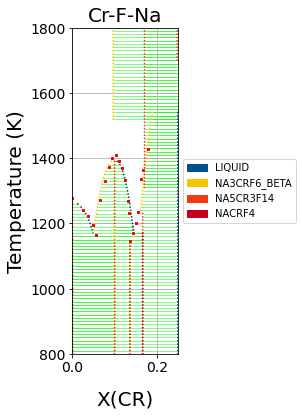

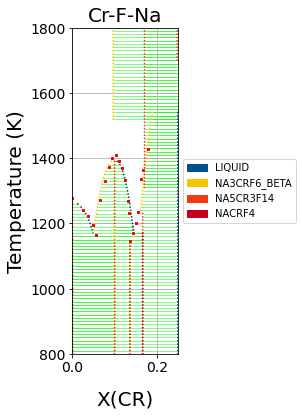

In [1]:
from pycalphad import Database, equilibrium, variables as v
from pycalphad.plot.eqplot import eqplot
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pycalphad.models.model_mqmqa import ModelMQMQA
dbf = Database('NaF-CrF3.tdb')
comps = ['CR', 'NA', 'F']
phases = list(dbf.phases.keys())

conds = {v.N: 1, v.P: 101325, v.T: (600,1800,10), v.X('NA'): 0.002512563, v.X('CR'):0.248743719}
eq_1 = equilibrium(dbf, comps, phases, conds, verbose=False, model={'LIQUID': ModelMQMQA})
conds = {v.N: 1, v.P: 101325, v.T: (600,1800,10), v.X('NA'): 0.115176402, v.X('CR'): 0.192411799}
eq_2 = equilibrium(dbf, comps, phases, conds, verbose=False, model={'LIQUID': ModelMQMQA})
conds = {v.N: 1, v.P: 101325, v.T: (600,1800,10), v.X('NA'): 0.480392157, v.X('CR'): 0.009803922}
eq_3 = equilibrium(dbf, comps, phases, conds, verbose=False, model={'LIQUID': ModelMQMQA})
conds = {v.N: 1, v.P: 101325, v.T: (600,1800,10), v.X('NA'): 0.157894737, v.X('CR'): 0.171052632}
eq_4 = equilibrium(dbf, comps, phases, conds, verbose=False, model={'LIQUID': ModelMQMQA})
conds = {v.N: 1, v.P: 101325, v.T: (600,1800,10), v.X('NA'): 0.214285714, v.X('CR'):0.142857143}
eq_5 = equilibrium(dbf, comps, phases, conds, verbose=False, model={'LIQUID': ModelMQMQA})
conds = {v.N: 1, v.P: 101325, v.T: (600,1800,10), v.X('NA'): 0.306451613, v.X('CR'):0.096774194}
eq_6 = equilibrium(dbf, comps, phases, conds, verbose=False, model={'LIQUID': ModelMQMQA})
conds = {v.N: 1, v.P: 101325, v.T: (600,1800,10), v.X('NA'): 0.293650794, v.X('CR'):0.103174603}
eq_7 = equilibrium(dbf, comps, phases, conds, verbose=False, model={'LIQUID': ModelMQMQA})
#conds = {v.N: 1, v.P: 101325, v.T: (500, 1600 ,100), v.X('K'): 0.4999, v.X('CR'): 0.0001}
#eq_2 = equilibrium(dbf, comps, phases, conds, verbose=False, model={'LIQUID': ModelMQMQA})

# print(eq_1.NP.values.squeeze())
# print(eq_2.NP.values.squeeze())

fig= plt.figure(figsize=(9,6))
ax = fig.add_subplot()

eqplot(eq_3, x=v.X('CR'), y=v.T, ax=ax)
eqplot(eq_7, x=v.X('CR'), y=v.T, ax=ax)
eqplot(eq_6, x=v.X('CR'), y=v.T, ax=ax)
eqplot(eq_2, x=v.X('CR'), y=v.T, ax=ax)
eqplot(eq_1, x=v.X('CR'), y=v.T, ax=ax)
eqplot(eq_4, x=v.X('CR'), y=v.T, ax=ax)
eqplot(eq_5, x=v.X('CR'), y=v.T, ax=ax)



ax.set_xlim(0, 0.25)
ax.set_ylim(800, 1800)

T=[1428,1363,1336,1234,1202,1169,1147,1233,1268,1334,1371,1390,1411,1400,1374,1329,1273,1163,1195,1224,1241,1277]
XCR=[0.17844832,0.167690181,0.162045705,0.156111585,0.150053542,0.144305328,0.137286906,0.133248247,0.130759233,0.124500586,0.116761327,0.110254971,0.102214868,0.0941229,0.086027604,0.076447069,0.066393784,0.056556752,0.04954955,0.03656502,0.025612197,0]

ax.plot(XCR, T, 'ro',ms=2,marker='s')

fig

In [1]:
from pycalphad import Database, calculate, Model, ReferenceState, variables as v
from tinydb import where
import matplotlib.pyplot as plt
import numpy as np
from sympy import exp, log, Abs, Add, And, Float, Mul, Piecewise, Pow, S
from collections import Counter
from pycalphad import equilibrium
from pycalphad.models.model_mqmqa import ModelMQMQA
from ast import literal_eval

dbf = Database("NaF-CrF3.tdb")
comps = ['NA', 'F','CR']


#phases = list(dbf.phases.keys())
phases=['LIQUID']

new_components={'CRF3':{'CR':1,'F':3},'NAF':{'NA':1,'F':1},'F2':{'F':2}}


Na_ref = ReferenceState('NA', "BCC_A2", {v.T: 298.15, v.P: 101325})
Cr_ref = ReferenceState('CR', "BCC_A2", {v.T: 298.15, v.P: 101325})
F_ref = ReferenceState('F', "GAS", {v.T: 298.15, v.P: 101325})

list_of_ref=[Cr_ref,Na_ref,F_ref]

eq_models={}
mod=ModelMQMQA(dbf,comps,phases[0])
mod.shift_reference_state(list_of_ref,dbf)
eq_models[phases[0]] = mod

conds = {v.N: 1,v.P: 101325, v.T: 350, v.X("NA"):0.499999990000000, v.X("CR"):4.99999995000000e-9}

result_NAF= equilibrium(dbf, comps, phases, conds, output='HMR',model=eq_models)
result_NAF2= equilibrium(dbf, comps, phases, conds, output='HM',model={'LIQUID': ModelMQMQA})

print(result_NAF)
print(result_NAF2)

This is site_frac_subs {BCC_A20CR: 1}
This is site_frac_subs {BCC_A20NA: 1}
This is site_frac_subs {GAS0F: 1}
<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, X_CR: 1, X_NA: 1, component: 3, internal_dof: 3, vertex: 4)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 350.0
  * X_CR       (X_CR) float64 5e-09
  * X_NA       (X_NA) float64 0.5
  * vertex     (vertex) int64 0 1 2 3
  * component  (component) <U2 'CR' 'F' 'NA'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_CR, X_NA, vertex) float64 1.0 nan nan nan
    GM         (N, P, T, X_CR, X_NA) float64 -2.883e+05
    MU         (N, P, T, X_CR, X_NA, component) float64 -8.967e+04 ... -1.537...
    X          (N, P, T, X_CR, X_NA, vertex, component) float64 4.998e-09 ......
    Y          (N, P, T, X_CR, X_NA, vertex, internal_dof) float64 1e-14 ... nan
    Phase      (N, P, T, X_CR, X_NA, vertex) <U6 'LIQUID' '' '' ''
    HMR        (

In [6]:
from pycalphad import Database, calculate, Model, ReferenceState, variables as v
from tinydb import where
import matplotlib.pyplot as plt
import numpy as np
from sympy import exp, log, Abs, Add, And, Float, Mul, Piecewise, Pow, S
from collections import Counter
from pycalphad import equilibrium
from pycalphad.models.model_mqmqa import ModelMQMQA
from ast import literal_eval

dbf = Database("NaF-CrF3.tdb")
comps = ['NA', 'F','CR']

phases = list(dbf.phases.keys())

#conds = {v.N: 1,v.P: 101325, v.T: 298.15, v.X("NA"):0.0, v.X("CR"):0.9999999}
conds = {v.N: 1,v.P: 101325, v.T: 298.15, v.X("NA"):0.9999999, v.X("CR"):0.0}

result_NAF2= equilibrium(dbf, comps, phases, conds,output='HM',model={'LIQUID': ModelMQMQA})

print(result_NAF2)

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, X_CR: 1, X_NA: 1, component: 3, internal_dof: 3, vertex: 4)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 298.1
  * X_CR       (X_CR) float64 1e-10
  * X_NA       (X_NA) float64 1.0
  * vertex     (vertex) int64 0 1 2 3
  * component  (component) <U2 'CR' 'F' 'NA'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_CR, X_NA, vertex) float64 1.998e-07 1.0 nan nan
    GM         (N, P, T, X_CR, X_NA) float64 -1.53e+04
    MU         (N, P, T, X_CR, X_NA, component) float64 -6.408e+04 ... -1.53e+04
    X          (N, P, T, X_CR, X_NA, vertex, component) float64 0.0 0.5 ... nan
    Y          (N, P, T, X_CR, X_NA, vertex, internal_dof) float64 1.0 ... nan
    Phase      (N, P, T, X_CR, X_NA, vertex) <U13 'NAF' 'BCC_A2' '' ''
    HM         (N, P, T, X_CR, X_NA) float64 -0.05597
Attributes:
    engine:   pycalphad 0.9.1.dev16+g0fd1bdbb.d2021070